# Bus AVL Project

Ehab Ebeid

## Setup

In [1]:
from __future__ import division, print_function

import numpy as np, sklearn

## Getting the Data

The dataset can be very large. First, set the parameters used to specify which data to import.

In [2]:
# minimum and maximum trip start datetime, in the format "yyyy-mm-dd hh:mi:ss", local time
FROM_DT = '2018-06-13 10:00:00'
TO_DT   = '2018-06-13 12:00:00'

# a single route pattern, which encodes the bus route and direction
ROUTE_PATTERN = '7901'

The AVL data is located in a local Microsoft SQL Server database. Connect to the database and import a selection of the data using the parameters above.

In [3]:
import pyodbc 
import pandas as pd

# connect to local database
cnxn = pyodbc.connect(Trusted_Connection='yes', 
                      driver = '{SQL Server}',
                      server = 'EHAB\SQLEXPRESS', 
                      database = 'raw_nav')

# join the tables route_run and gps_reading, using the filters specified above
query = """select 
            r.id as route_run_id,
            r.route_pattern,
            r.bus_id,
            r.svc_date,
            r.trip_start_datetime,
            g.id as gps_reading_id,
            g.lat_fixed as lat,
            g.lon_fixed as lon,
            g.heading_deg,
            g.door_state,
            g.vehicle_state,
            g.odo_feet,
            g.time_seconds,
            g.sat_count,
            g.stop_window_data

        from raw_nav.dbo.route_run as r
        join raw_nav.dbo.gps_reading as g
        on r.id = g.route_run_id
        
        where trip_start_datetime between '{start}' and '{end}'
          and route_pattern = '{pattern}'
        ;
        """.format(start=FROM_DT, end=TO_DT, pattern=ROUTE_PATTERN)

# grab as a pandas dataframe
df = pd.read_sql_query(query, cnxn)


## Let's take a look!

In [4]:
# summarise the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13962 entries, 0 to 13961
Data columns (total 15 columns):
route_run_id           13962 non-null int64
route_pattern          13962 non-null object
bus_id                 13962 non-null object
svc_date               13962 non-null object
trip_start_datetime    13962 non-null datetime64[ns]
gps_reading_id         13962 non-null int64
lat                    13962 non-null float64
lon                    13962 non-null float64
heading_deg            13962 non-null int64
door_state             13962 non-null object
vehicle_state          13962 non-null object
odo_feet               13962 non-null int64
time_seconds           13962 non-null int64
sat_count              13962 non-null int64
stop_window_data       348 non-null object
dtypes: datetime64[ns](1), float64(2), int64(6), object(6)
memory usage: 1.6+ MB


In [5]:
# first five rows
df.head()

,route_run_id,route_pattern,bus_id,svc_date,trip_start_datetime,gps_reading_id,lat,lon,heading_deg,door_state,vehicle_state,odo_feet,time_seconds,sat_count,stop_window_data
0,46714,7901,6451,06/13/18,2018-06-13 10:12:30,64088010,38.994025,-77.030545,220,C,M,0,0,6,None
1,46714,7901,6451,06/13/18,2018-06-13 10:12:30,64088011,38.993985,-77.030590,199,C,M,11,1,5,None
2,46714,7901,6451,06/13/18,2018-06-13 10:12:30,64088012,38.993940,-77.030619,178,C,M,29,2,6,None
3,46714,7901,6451,06/13/18,2018-06-13 10:12:30,64088013,38.993940,-77.030619,178,C,M,30,2,6,X-1
4,46714,7901,6451,06/13/18,2018-06-13 10:12:30,64088014,38.993940,-77.030619,178,C,M,31,2,6,E00


It would be useful to see how many route runs, or trips, are included in the data.

In [6]:
ntrips = df.trip_start_datetime.unique().shape
print (ntrips)

(10L,)


There are **10 trips** with start times between 10 am and noon on 13 June 2018. 

It would be useful to plot them out as time-space diagrams. Doing so is easiest with timestamps for each GPS reading, which we are missing. Instead we have the `time_seconds` field, which is the number of seconds elapsed since the start of the trip. Let's create a `timestamp` field.

In [7]:
df['timestamp'] = df.trip_start_datetime + pd.to_timedelta(df['time_seconds'], unit='s')

df.head()

,route_run_id,route_pattern,bus_id,svc_date,trip_start_datetime,gps_reading_id,lat,lon,heading_deg,door_state,vehicle_state,odo_feet,time_seconds,sat_count,stop_window_data,timestamp
0,46714,7901,6451,06/13/18,2018-06-13 10:12:30,64088010,38.994025,-77.030545,220,C,M,0,0,6,None,2018-06-13 10:12:30
1,46714,7901,6451,06/13/18,2018-06-13 10:12:30,64088011,38.993985,-77.030590,199,C,M,11,1,5,None,2018-06-13 10:12:31
2,46714,7901,6451,06/13/18,2018-06-13 10:12:30,64088012,38.993940,-77.030619,178,C,M,29,2,6,None,2018-06-13 10:12:32
3,46714,7901,6451,06/13/18,2018-06-13 10:12:30,64088013,38.993940,-77.030619,178,C,M,30,2,6,X-1,2018-06-13 10:12:32
4,46714,7901,6451,06/13/18,2018-06-13 10:12:30,64088014,38.993940,-77.030619,178,C,M,31,2,6,E00,2018-06-13 10:12:32


That's more like it! Now we can plot the trips.

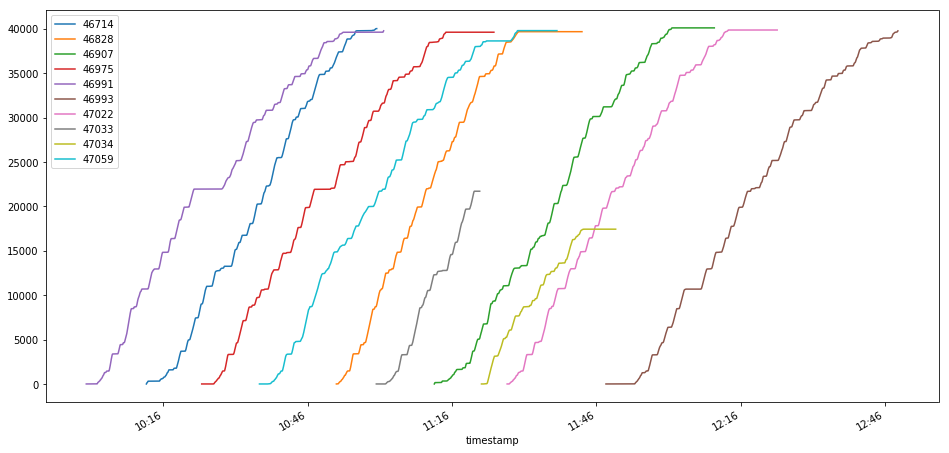

In [9]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# time-space diagrams of the trips returned
fig, ax = plt.subplots()
for name, group in df.groupby('route_run_id'):
    group.plot(x='timestamp', y='odo_feet', figsize=(16,8), ax=ax, label=name)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

We notice that most trips have approximately the same maximum odometer reading, at around 40,000 feet. This is to be expected since they are all on the same route and direction.

**However**, two trips stand out as erroneous: route run 47033 (grey) and 47034 (light green) are shorter than the others. Because route run 47034 starts at around the same time that 47033 ends, it is reasonable to conclude that this is a case of the bus odometer resetting to zero mid-trip. This is by far the most common case of erroneous data.

%% HTML
<script type='text/javascript' src='https://us-east-1.online.tableau.com/javascripts/api/viz_v1.js'></script><div class='tableauPlaceholder' style='width: 1536px; height: 640px;'><object class='tableauViz' width='1536' height='640' style='display:none;'><param name='host_url' value='https%3A%2F%2Fus-east-1.online.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='&#47;t&#47;ehabebeid' /><param name='name' value='BusAVL&#47;Dashboard' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='showAppBanner' value='false' /><param name='filter' value='iframeSizedToWindow=true' /></object></div>

## Cleaning the Data

In [ ]:
# TODO: calculate median odometer reading M, remove trips with odometer readings of >1.05M or <0.95M